<a href="https://colab.research.google.com/github/jubair231dd/ML/blob/main/MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libaries

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
print('Using PyTorch version:', torch.__version__ , ' Device:', device)

Using PyTorch version: 1.13.1+cu116  Device: cuda


## Data
Next we'll load the MNIST data. First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for validation, instead of for testing the final model.

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (X_train) is a 4th-order tensor of size (batch_size, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. y_train is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

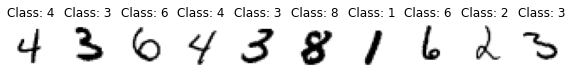

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

MLP network definition
Let's define the network as a Python class. We have to write the __init__() and forward() methods, and PyTorch will automatically generate a backward() method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients. We select stochastic gradient descent (with momentum) as the optimization algorithm, and set learning rate to 0.01. Note that there are several different options for the optimizer in PyTorch that we could use instead of SGD.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        # print(x)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


# Learning
Let's now define functions to train() and validate() the model.

In [ ]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [ ]:

%%time
epochs = 15

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323652
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.230086
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.095607
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.725296
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.367298
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.082830
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.095152
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.705226
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.746257
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.434700

Validation set: Average loss: 0.5047, Accuracy: 8666/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.676672
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.567990
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.649180
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.795443
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.359674
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.454839
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.496732
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.582828
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.53

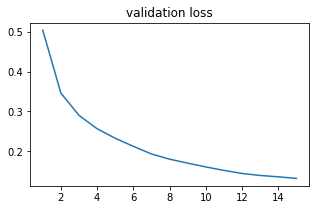

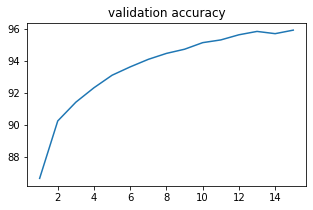

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [ ]:
!pip install talos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 92.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41609 sha256=358e316929b47ec897d8477cad182870b016139621c200efd2addbc14afe4a31
  Stored in directory: /root/.cache/pip/wheels/bc/47/dc/208d4038848287f804b6ededf43632ba7dbea530fdb3a069e4
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=19d801b4843f8fe0d8b395c0ca0f9733c52cd474d09897bd487d473cdf4f830a
  Stor

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import talos


# Define the model
class MyModel(nn.Module):
    def __init__(self, units, activation):
        super(MyModel, self).__init__()
        self.units = units
        self.activation = activation
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(28*28, units)
        self.dense2 = nn.Linear(units, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = getattr(nn, self.activation)()(x)
        x = self.dense2(x)
        return x


# Define the training function
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        train_acc += torch.sum(preds == target.data)
        
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_acc.double() / len(train_loader.dataset)
    
    return epoch_loss, epoch_acc


# Define the validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            val_acc += torch.sum(preds == target.data)
            
    epoch_loss = val_loss / len(val_loader.dataset)
    epoch_acc = val_acc.double() / len(val_loader.dataset)
    
    return epoch_loss, epoch_acc


# Define the experiment function
def my_model(x_train, y_train, x_val, y_val, params):
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    model = MyModel(units=params['units'], activation=params['activation']).to(device)
    criterion = getattr(nn, params['loss'])()
    optimizer = getattr(optim, params['optimizer'])(model.parameters())
    
    for epoch in range(params['epochs']):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.5f}")
    
    return {'loss': val_loss, 'accuracy': val_acc}
